<a href="https://colab.research.google.com/github/nyunu/IT_DataMining/blob/main/IT%EC%99%80%EB%B9%84%EC%A6%88%EB%8B%88%EC%8A%A4%ED%98%81%EC%8B%A0_%EB%B6%84%EB%A5%98%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,532 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import matplotlib.font_manager as fm

In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve

### 이전 과제에서 전처리한 데이터를 사용 <br>
**전처리 과정**<br>
1. 건강검진 결과에 영향을 주지 않는 변수 삭제 <br>
  : '기준년도', '데이터공개일자', '가입자일련번호' 변수 삭제 <br>
2. 결측치 처리 <br> 
  1) 구강검진 관련 변수 ('치아우식증유무', '치석') 결측치 보간
  2) 결측치 개수가 적은 변수는 각 변수의 평균을 이용하여 결측치 보간 <br> ex) 음주여부(1), 흡연상태(2), 수축기혈압(88), 이완기혈압(88), 식전혈당(88), 혈색소(88), 혈청크레아티닌(88),(혈청지오티)AST(88), (혈청지오티)ALT(88), 감마지티피(88), 요단백(139)
  3) 콜레스테롤 관련 변수 삭제 

In [4]:
df_health = pd.read_csv("/content/drive/MyDrive/health.csv")
df_health.drop('Unnamed: 0', axis = 1, inplace = True)
df_health.head()

,시도코드,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),...,흡연상태,음주여부,구강검진수검여부,치아우식증유무,치석,혈청크레아티닌_정상여부,(혈청지오티)AST_정상여부,(혈청지오티)ALT_정상여부,감마지티피_정상여부,심정지 질환 위험군
0,36,0,9,165,60,72.1,1.2,1.5,1,1,...,0,0,0,2.0,2.0,1,1,1,1,0
1,31,0,13,160,70,90.8,1.0,1.0,1,2,...,0,0,1,0.0,0.0,1,0,0,0,1
2,27,0,9,185,85,94.0,1.2,1.2,1,1,...,1,1,0,2.0,2.0,1,1,1,1,0
3,44,0,9,165,80,93.0,0.8,0.7,1,2,...,1,1,1,0.0,1.0,0,1,1,1,0
4,41,0,13,160,65,92.0,0.5,0.5,1,1,...,1,0,1,0.0,2.0,1,1,1,1,1


In [5]:
df_health.columns

Index(['시도코드', '성별코드', '연령대코드(5세단위)', '신장(5Cm단위)', '체중(5Kg 단위)', '허리둘레',
       '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태',
       '음주여부', '구강검진수검여부', '치아우식증유무', '치석', '혈청크레아티닌_정상여부', '(혈청지오티)AST_정상여부',
       '(혈청지오티)ALT_정상여부', '감마지티피_정상여부', '심정지 질환 위험군'],
      dtype='object')

# **주제 : 고혈압 여부 분류**
### **고혈압의 원인** 
① 심혈관 질환의 가족력(유전) <br>
② 흡연 <br>
③ 고지혈증<br>
④ 당뇨병<br>
⑤ 60세 이후 노년층<br>
⑥ 성별(남성과 폐경 이후 여성)<br>
⑦ 식사성 요인 : Na, 지방 및 알코올의 과잉 섭취, K, Mg, Ca의 섭취 부족<br>
⑧ 약물 요인 : 경구 피임약, 제산제, 항염제, 식욕억제제<br><br>

### **고혈압의 원인 중 데이터 셋 내에 존재하는 변수**
아래의 변수를 **종속변수**로 사용 <br>
① '연령대코드(5세단위)' <br>
② '성별코드' <br>
③ '흡연상태' <br>
④ '음주여부' <br><br>

### **고혈압 여부 판단 기준**
아래 중 하나 이상 만족하면 고혈압으로 판단 <br>
① 수축기혈압 >= 135 <br>
② 이완기 혈압 >= 95 <br><br>

## **고혈압 여부 판단에 사용할 변수**
아래의 변수를 이용하여 위의 기준에 따라 판단한 '고혈압여부'라는 새로운 파생변수를 생성하여 이를 **독립변수**로 사용<br>
① '수축기혈압' <br>
② '이완기 혈압' <br><br>

출처) 서울아산내과 질환백과 (https://www.amc.seoul.kr/asan/healthinfo/disease/diseaseDetail.do?contentId=31322) 

## **1. 고혈압 여부를 판단하는 파생변수 생성**
0: 정상 <br>
1: 고혈압 <br>

In [6]:
df_health['고혈압여부'] = 0

In [7]:
df_health.loc[(df_health['수축기혈압'] >= 135) | (df_health['이완기혈압'] >= 95), "고혈압여부"] = 1

In [8]:
df_health['고혈압여부'].value_counts()

0    7560
1    2440
Name: 고혈압여부, dtype: int64

## **2. 사용할 종속변수와 독립변수만으로 새로운 데이터셋 생성**

### **변수설명** <br>
흡연상태 -> 0: 비흡연 / 1: 흡연 <br>
음주여부 -> 0: 금주 / 1: 음주 <br>
고혈압여부 -> 0: 정상 / 1: 고혈압 <br>
연령대코드 -> <br> 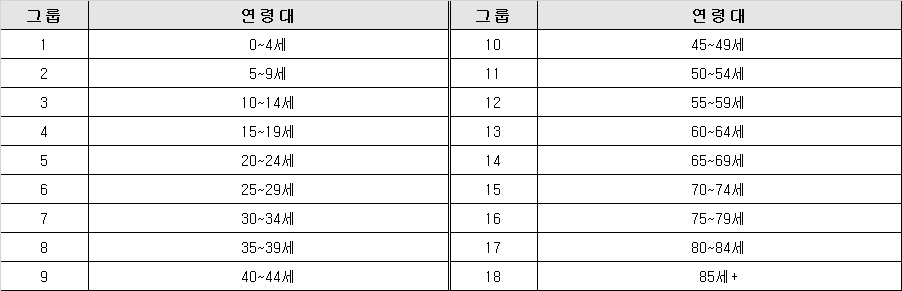 <br>


In [9]:
df = df_health[['흡연상태', '음주여부', '연령대코드(5세단위)', '성별코드', '고혈압여부']]
df.head()

,흡연상태,음주여부,연령대코드(5세단위),성별코드,고혈압여부
0,0,0,9,0,0
1,0,0,13,0,0
2,1,1,9,0,0
3,1,1,9,0,0
4,1,0,13,0,0


## **3. 모델링 및 성능 평가**

In [10]:
X = df.iloc[:, :4]
y = df.iloc[:, 4]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

* DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier 세 가지 모델을 사용
* 평가지표로는 교차 검증 결과(정확도)의 평균값 사용

In [45]:
kf = StratifiedKFold(n_splits=10)

tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
gbrt = GradientBoostingClassifier()

dt_scores = cross_val_score(tree, X_train, y_train, cv=kf, scoring='accuracy')  
rf_scores = cross_val_score(forest, X_train, y_train, cv=kf, scoring='accuracy')
gbrt_scores = cross_val_score(gbrt, X_train, y_train, cv=kf, scoring='accuracy')

print("Decision tree :{:.3f}".format(dt_scores.mean())) 
print("Random forest :{:.3f}".format(rf_scores.mean())) 
print("Gradient boosting :{:.3f}".format(gbrt_scores.mean())) 

Decision tree :0.754
Random forest :0.754
Gradient boosting :0.757


GradientBoostingClassifier의 정확도가 가장 높은 것을 근거로 해당 모델을 최종 모델로 채택하고 모델링 진행

In [46]:
parameters = {'max_depth':[1,2,3], 'learning_rate':[0.1,0.08, 0.06, 0.04, 0.02]}
init_gbrt = GradientBoostingClassifier(random_state=0)
grid_gbrt = GridSearchCV(init_gbrt, param_grid=parameters, cv=3, refit=True)
grid_gbrt.fit(X_train, y_train)
print('GridSearchCV 최적 파라미터:', grid_gbrt.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_gbrt.best_score_))
print("시험용 데이터 세트 정확도: {:.3f}".format(grid_gbrt.score(X_test, y_test)))

GridSearchCV 최적 파라미터: {'learning_rate': 0.1, 'max_depth': 1}
GridSearchCV 최고 정확도: 0.7575
시험용 데이터 세트 정확도: 0.752


최종 Accuracy<br>
* train data = 0.7575
* test data = 0.752

## **5. 변수 중요도**


In [48]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importances_health(model):
    plt.rcParams["figure.figsize"] = (9,6)
    n_features = len(X_train.columns)  # 30개 
    plt.barh(np.arange(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns)   # 30개의 눈금을 표시하고 눈금 레이블을 변수 이름으로 지정
    plt.xlabel("feature importance")
    plt.ylabel("feature")
    plt.ylim(-1, n_features) #Y 축 범위 지정 (-1 ~ 30)

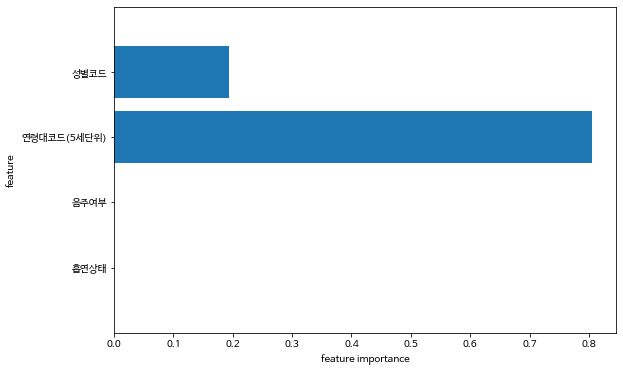

In [52]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate = 0.1, max_depth = 1)
gbrt.fit(X_train, y_train)
plot_feature_importances_health(gbrt)

In [54]:
columns = X_train.columns
feature_importance = pd.DataFrame(gbrt.feature_importances_.reshape((1, -1)), columns=columns, index=['feature_importance'])
feature_importance 

,흡연상태,음주여부,연령대코드(5세단위),성별코드
feature_importance,0.000497,0.0,0.805872,0.193632


In [55]:
df_copy = df_health[df_health['고혈압여부']==1]
part = pd.DataFrame(df_copy.groupby("연령대코드(5세단위)")['고혈압여부'].count())
all = pd.DataFrame(df_health.groupby("연령대코드(5세단위)")['시도코드'].count())
df_copy = pd.concat([part, all], axis = 1)
df_copy.columns = ['part' , 'all']
df_copy['%'] = df_copy['part'] / df_copy['all']
df_copy

,part,all,%
연령대코드(5세단위),,,
9,257,1547,0.166128
10,243,1369,0.177502
11,376,1798,0.209121
12,333,1498,0.222296
13,425,1534,0.277053
14,292,865,0.337572
15,256,698,0.366762
16,142,377,0.376658
17,100,259,0.386100


## **6. 결론**

* 변수의 중요도를 파악해보았을 때 약 80%정도를 '연령대코드(5세단위)'가 차지하며 해당 변수의 중요도가 상당히 크다는 것을 파악할 수 있다.
* 실제로 ~39세까지는 고혈압군에 해당하는 사람이 존재하지 않았으며 40세 이상의 연령대부터가 고혈압군에 해당함을 확인할 수 있다.
* 또한, 전체와 대비해 고혈압 환자의 비율을 살펴보았을 때, 나이대가 올라갈 수록 고혈압 환자의 비율이 대체적으로 상승하고 있음을 확인할 수 있다.